# Introduction
In my previous kernel, I explored [deep learning with Keras](https://www.kaggle.com/bertcarremans/deep-learning-for-sentiment-analysis) on the [TwitterAirline data set](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). The model with Dropout layers produced the best results. However, it was still outperformed by the LogisticRegression model. Let's try if we can do better than the LogisticRegression with a deep learning model that uses word embeddings. 

In this kernel we will:
* use the Embedding layer of Keras to create word embeddings from the training data
* use pretrained word embeddings trained on a much larger corpus

# Word Embeddings
When applying one-hot encoding to the words in the tweets, we end up with sparse vectors of high dimensionality (here the number of words). On larger data sets this could cause performance issues. Additionally, one-hot encoding does not take into account the semantics of the words. For instance, *plane* and *aircraft* are different words but have a similar meaning. 

Word embeddings reduce these two issues. Word embeddings are dense vectors with a much lower dimensionality. Secondly, the semantic relationships between words are reflected in the distance and direction of the vectors.  

# Set-up of the project

In [1]:
# Basic packages
from typing import List, Tuple, Dict, Any
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import gensim

# Packages for modeling
# from keras import models
# from keras import layers
# from keras import regularizers

from tensorflow.keras import (models, layers, regularizers)
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Embedding, Flatten
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, Flatten, Dense



# Get NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adeid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 128  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 24  # Maximum number of words in a sequence
GLOVE_DIM = 50  # Number of dimensions of the GloVe word embeddings
INITIAL_VECTOR_DIM = 100
WORD2_VEC_DIM = 300 # Number of dimensions of the word2vec word embeddings
INPUT_PATH = '../input'  # Path where all input files are stored
word2vec_path = "./models/GoogleNews-vectors-negative300.bin" # Path to Word2vec "Google News" vectors

In [3]:
root = Path('../')
input_path = root / 'input/' 
ouput_path = root / 'output/'
source_path = root / 'source/'

# Some helper functions

In [4]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    # Early stop
    early_stop_callback = EarlyStopping(
        monitor='val_loss',         # Metric to monitor (validation loss is common)
        min_delta=0.001,            # Minimum change in the monitored quantity to count as an improvement
        patience=5,                 # Number of epochs with no improvement after which training will be stopped
        verbose=1,                  # Prints a message when stopping
        mode='min',                 # Stop when the monitored quantity stops decreasing (for loss)
        restore_best_weights=True   # Restores model weights from the epoch with the best value of the monitored quantity
    )
    
    # optimizer='rmsprop'
    model.compile(optimizer='adam'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , callbacks=[early_stop_callback] # Add the defined callback here
                       , verbose=1)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    # e = range(1, NB_START_EPOCHS + 1)
    e = range(1, len(metric) + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

def convert_keyed_vectors_2_dict(word2vec_model: gensim.models.keyedvectors.KeyedVectors) -> Dict[str, np.array]:
    """
    Converts the KeyedVectors object to a python dictionary
    :param word2vec_model: Word2vec model
    :returns: Dictionary of words (keys) and vectors (values)
    """
    word_vectors_dict = {word: word2vec_model[word] for word in word2vec_model.index_to_key}
    return word_vectors_dict

# Data Preparation
### Reading and cleaning data

In [5]:
data_dir = "data/"


In [6]:
def get_airline_sentiment_data():
    """
    Gets the airline sentiment data
    :returns: airline sentiment dataset
    """
    tweets_data_path = f"{data_dir}Tweets.csv"
    df = pd.read_csv(tweets_data_path)
    df = df.reindex(np.random.permutation(df.index))  
    df = df[['text', 'airline_sentiment']]
    df.rename(columns={"airline_sentiment": "sentiment"}, inplace=True)
    df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
    return df

def get_financial_sentiment_data():
    """
    Gets the financial sentiment data
    :returns: financial sentiment dataset
    """
    financial_sentiment_data_path = f"{data_dir}financial_sentiment_data.csv"
    df = pd.read_csv(financial_sentiment_data_path, encoding = "ISO-8859-1")
    df = df.reindex(np.random.permutation(df.index))  
    df = df[['sentiment', 'text']]
    df_reordered = df.iloc[:, [1, 0]]
    df_reordered.text = df_reordered.text.apply(remove_stopwords).apply(remove_mentions)
    return df_reordered
    

In [7]:
# df = get_airline_sentiment_data()
df = get_financial_sentiment_data()
df.head()

,text,sentiment
4390,As capacity cut 1.4 passenger load factor 7.8 ...,negative
4528,The EB Tough VoIP Field Phone equipped integra...,neutral
1869,The Moscow Metro www.mosmetro.ru first metro s...,neutral
3047,Niina Nenonen Marimekko 's current director cl...,neutral
3037,M-real Corporation Stock Exchange Release 27 A...,neutral


### Train-Test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 4361
# Test data samples: 485


### Converting words to numbers

In [9]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [10]:
print(f"type(X_train): {type(X_train)}\n")
X_train.head()

type(X_train): <class 'pandas.core.series.Series'>



889     The acquisition Kaupthing Sverige bring signif...
4778    `` Low energy consumption flexible loading adv...
136     `` The priority 2009 strengthen company 's bal...
3379    The total size complex around 25,000 m2 projec...
4055    Finnish forest machinery manufacturer Ponsse i...
Name: text, dtype: object

In [11]:
print(f"type(X_train_seq): {type(X_train_seq)}\n")
print(f"1st tweet is: {X_train.values[0]}")
X_test_seq[0]

type(X_train_seq): <class 'list'>

1st tweet is: The acquisition Kaupthing Sverige bring significant positive non-recurring addition group 's performance


[18, 13, 249, 207, 26, 77, 1463, 39, 10, 8, 77, 41, 51, 68, 26, 82]

### Creating word sequences of equal length
Before we can compute the word embeddings, we need to make sure the sequences are of equal length. In the example below, we truncate sequences to length MAX_LEN, or pad them with zeroes to achieve this. First, we'll have a look at the length of the (cleaned) tweets.

In [12]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    4361.000000
mean       14.019491
std         6.262663
min         1.000000
25%         9.000000
50%        13.000000
75%        18.000000
max        45.000000
Name: text, dtype: float64

In [13]:
MAX_LEN = int(seq_lengths.describe()["max"])

Based on the figures above we will set MAX_LEN to 24. So this means we will not be truncating any words, only pad with zeros. This is to avoid to lose information as the tweets are rather short.

In [14]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [15]:
X_train_seq_trunc[10]  # Example of padded sequence

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,   92,   50,
       4695,    3,    6, 1870,  783,   32,  533,  349,   11,    8,  149,
       1203,   91,   56,   91, 4696, 2135,  828,  534,  133,   75, 1204,
       1871], dtype=int32)

### Converting the target classes to numbers

In [16]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

### Splitting off validation data

In [17]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (437, 45)


In [18]:
NB_WORDS

10000

# Modeling

### Training word embeddings
Keras provides an **Embedding layer** which helps us to train specific word embeddings based on our training data. It will convert the words in our vocabulary to multi-dimensional vectors. 

In [19]:
emb_model = models.Sequential()
#model.add(layers.Input(shape=(MAX_LEN,))) 
#emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Embedding(NB_WORDS, INITIAL_VECTOR_DIM))
emb_model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=False)))
emb_model.add(layers.Dropout(0.5))
# emb_model.add(layers.Flatten())
emb_model.add(layers.GlobalAveragePooling1D())
emb_model.add(layers.Dense(3, activation='softmax'))
#emb_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
emb_model.build(input_shape=(BATCH_SIZE, MAX_LEN))
emb_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (128, 45, 100)              │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (128, 128)                  │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (128, 128)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (128, 128)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (128, 3)                    │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,084,867 (4.14 MB)

 Trainable params: 1,084,867 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.5844 - loss: 0.9375 - val_accuracy: 0.6041 - val_loss: 0.9032
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6524 - loss: 0.7744 - val_accuracy: 0.6453 - val_loss: 0.7933
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7668 - loss: 0.5646 - val_accuracy: 0.6613 - val_loss: 0.7761
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8313 - loss: 0.4033 - val_accuracy: 0.6568 - val_loss: 0.8236
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8570 - loss: 0.3140 - val_accuracy: 0.6522 - val_loss: 0.9237
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9052 - loss: 0.2436 - val_accuracy: 0.6796 - val_loss: 1.0003
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9539 - loss: 0.1525 - val_accuracy: 0.6796 - val_loss: 1.0853
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9704 - loss: 0.0980 - val_accuracy: 0.6682 - v

We have a validation accuracy of about 77%. The number of words in the tweets is rather low, so this result is rather good. 

By comparing the training and validation accuracy and loss, we see that the model starts overfitting from epoch 6..

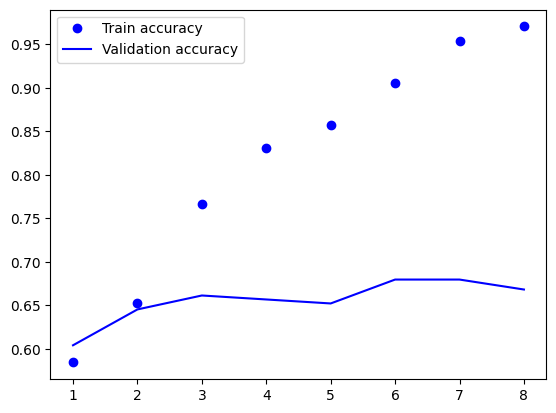

In [21]:
eval_metric(emb_history, 'accuracy')

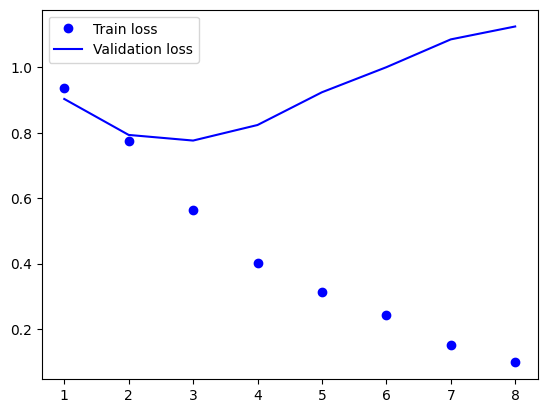

In [22]:
eval_metric(emb_history, 'loss')

In [23]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7402 - loss: 1.1656
/n
Test accuracy of word embeddings model: 74.02%


This test result is quite ok, but still not better than the other deep learning model with Dropout layers, nor the LogisticRegression. Let's see if we can improve with pretrained word embeddings.

### Using pre-trained word embeddings
Because the training data is not so big, the model might not be able to learn good embeddings for the sentiment analysis. Luckily we can load pre-trained word embeddings built on a much larger training data. 

The [GloVe database](https://nlp.stanford.edu/projects/glove/) contains multiple pre-trained word embeddings, and more specific embeddings trained on tweets. But I am going to use the Google News word2vec pre-trained embeddings model

In [25]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=200000) 
emb_dict = convert_keyed_vectors_2_dict(word2vec_model)

Let's test if we can find some airline related words in the dictionary.

In [26]:
airline_words = ['airplane', 'airline', 'flight', 'luggage']
for w in airline_words:
    if w in emb_dict.keys():
        print('Found the word {} in the dictionary'.format(w))

Found the word airplane in the dictionary
Found the word airline in the dictionary
Found the word flight in the dictionary
Found the word luggage in the dictionary


To feed this into an Embedding layer, we need to build a matrix containing the words in the tweets and their representative word embedding. So this matrix will be of shape (NB_WORDS, GLOVE_DIM)

In [27]:
emb_matrix = np.zeros((NB_WORDS, WORD2_VEC_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [28]:
w2v_model = models.Sequential()
w2v_model.add(layers.Embedding(NB_WORDS, WORD2_VEC_DIM, input_length=MAX_LEN))
w2v_model.add(layers.Dropout(0.5))
w2v_model.add(layers.Flatten())
w2v_model.add(layers.Dense(3, activation='softmax'))
w2v_model.build(input_shape=(BATCH_SIZE, MAX_LEN))
w2v_model.summary()

C:\Users\adeid\miniconda3\envs\ai_thursdays_env_312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (128, 45, 300)              │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (128, 45, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (128, 13500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (128, 3)                    │          40,503 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,040,503 (11.60 MB)

 Trainable params: 3,040,503 (11.60 MB)

 Non-trainable params: 0 (0.00 B)

With the *set_weights* method we load the pre-trained embeddings in the Embedding layer (here layer 0). By setting the *trainable* attribute to False, we make sure not to change the pre-trained embeddings.

In [29]:
w2v_model.layers[0].set_weights([emb_matrix])
w2v_model.layers[0].trainable = False

In [30]:
glove_history = deep_model(w2v_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6065 - loss: 0.9169 - val_accuracy: 0.6201 - val_loss: 0.8735
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6774 - loss: 0.7696 - val_accuracy: 0.6362 - val_loss: 0.8286
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7095 - loss: 0.7023 - val_accuracy: 0.6339 - val_loss: 0.8065
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7327 - loss: 0.6655 - val_accuracy: 0.6476 - val_loss: 0.7878
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7617 - loss: 0.6163 - val_accuracy: 0.6499 - val_loss: 0.7719
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7650 - loss: 0.5869 - val_accuracy: 0.6796 - val_loss: 0.7628
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7859 - loss: 0.5598 - val_accuracy: 0.6819 - val_loss: 0.7560
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7959 - loss: 0.5389 - val_accuracy: 0.6796 - v

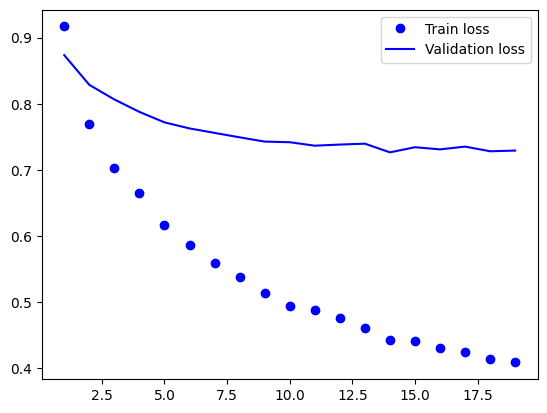

In [31]:
eval_metric(glove_history, 'loss')

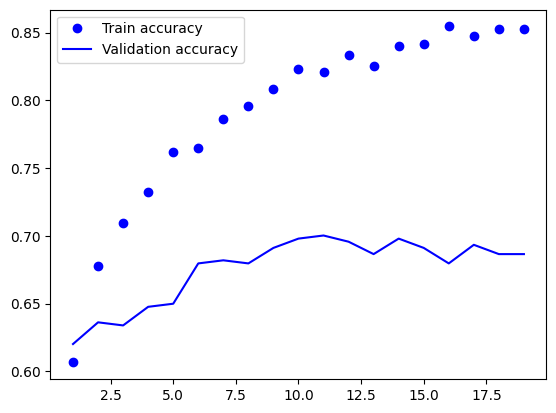

In [32]:
eval_metric(glove_history, 'accuracy')

In [33]:
glove_results = test_model(w2v_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7113 - loss: 0.6973 
/n
Test accuracy of word glove model: 71.13%


The model overfits fast, after 3 epochs. Moreover the validation accuracy is lower compared to the embeddings trained on the training data. 

As a final exercise, let's see what results we get when we train the embeddings with the same number of dimensions as the GloVe data.

### Training word embeddings with more dimensions

In [34]:
emb_model2 = models.Sequential()
emb_model2.add(layers.Embedding(NB_WORDS, WORD2_VEC_DIM, input_length=MAX_LEN))
#emb_model2.add(layers.Dropout(0.5))
emb_model2.add(layers.Bidirectional(layers.LSTM(64, return_sequences=False)))
#emb_model2.add(layers.Flatten())
# emb_model2.add(layers.Dense(128, activation='relu'))
emb_model2.add(layers.Dropout(0.2))
emb_model2.add(layers.Dense(3, activation='softmax'))
emb_model2.build(input_shape=(BATCH_SIZE, MAX_LEN))
emb_model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (128, 45, 300)              │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (128, 128)                  │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (128, 128)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (128, 3)                    │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,187,267 (12.16 MB)

 Trainable params: 3,187,267 (12.16 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
emb_history2 = deep_model(emb_model2, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.5966 - loss: 0.9014 - val_accuracy: 0.6293 - val_loss: 0.8690
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7031 - loss: 0.6721 - val_accuracy: 0.6613 - val_loss: 0.7599
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.8397 - loss: 0.3842 - val_accuracy: 0.7483 - val_loss: 0.6974
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9450 - loss: 0.1819 - val_accuracy: 0.7162 - val_loss: 0.7932
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9730 - loss: 0.1016 - val_accuracy: 0.7300 - val_loss: 0.9872
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9845 - loss: 0.0605 - val_accuracy: 0.6865 - val_loss: 1.0759
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9870 - loss: 0.0529 - val_accuracy: 0.6979 - val_loss: 1.1740
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9888 - loss: 0.0441 - val_accuracy: 0.

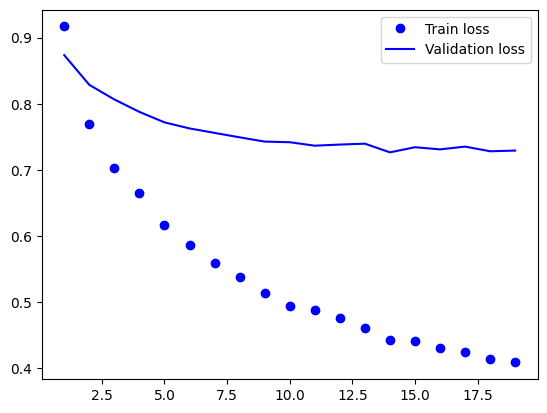

In [36]:
eval_metric(glove_history, 'loss')

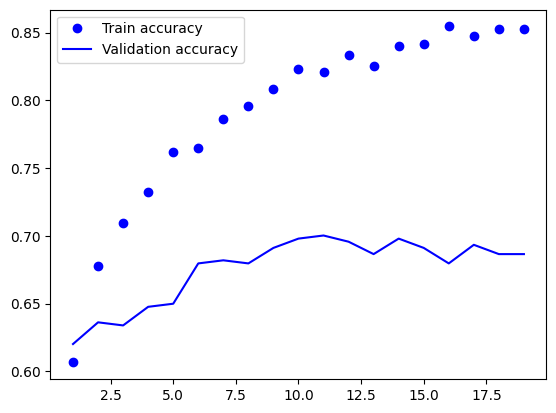

In [37]:
eval_metric(glove_history, 'accuracy')

In [38]:
emb_results2 = test_model(emb_model2, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word embedding model 2: {0:.2f}%'.format(emb_results2[1]*100))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7216 - loss: 1.0012
/n
Test accuracy of word embedding model 2: 72.16%


This result is very close to the model with 8-dimensional word embeddings. So there is no strong improvement. 

# Conclusion
The best result is achieved with 8-dimensional word embeddings that are trained on the available data. This even outperforms the use of word embeddings that were trained on a much larger Twitter corpus. 

Until now we have just put a Dense layer on the flattened embeddings. By doing this, we do not take into account the relationships between the words in the tweet. This can be done with a recurrent neural network or a 1D convolutional network, which I'll cover in another kernel.
